In [1]:
import pandas as pd
import numpy as np

with open('../datasets/mimic2/mimic2.attr') as f:
    featureNames = []
    for line in f.readlines():
        featureNames.append(line[:line.find(':')])
with open('../datasets/mimic2/mimic2_cont_missing.data') as f:
    data_orig = pd.read_csv(f,' ',header=None, na_values='N/A')
data_orig.columns = featureNames

In [2]:
for feature in ['AdmissionType', 'AIDS', 'MetastaticCancer' , 'Lymphoma', 'HospitalMortality']:
    data_orig[feature] = data_orig[feature].astype('int64')

In [3]:
data_imputeleft = data_orig.fillna(-5)

In [4]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

train_cols = data_imputeleft.columns[0:-1]
label = data_imputeleft.columns[-1]
X = data_imputeleft[train_cols]
y = data_imputeleft[label]
ebm = ExplainableBoostingClassifier(outer_bags = 100, inner_bags= 50, interactions=0,random_state=1, n_jobs=-1)
ebm.fit(X, y)   #Works on dataframes and numpy arrays

ExplainableBoostingClassifier(feature_names=['Age', 'GCS', 'SBP', 'HR',
                                             'Temperature', 'PFratio', 'Renal',
                                             'Urea', 'WBC', 'CO2', 'Na', 'K',
                                             'Bilirubin', 'AdmissionType',
                                             'AIDS', 'MetastaticCancer',
                                             'Lymphoma'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'categor

In [5]:
total_bins = 1
for scores in ebm.additive_terms_:
    total_bins+=scores.shape[0]-1
print(total_bins)
        

1462


In [6]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/4482943296/ -->

In [7]:
is_missing = data_orig.isnull().sum(0)>0

In [8]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import ttest_ind

feature name: SBP
10970 10970
p value: Ttest_indResult(statistic=-20.92353273653343, pvalue=1.0624192166483449e-95)
feature name: HR
765 765
p value: Ttest_indResult(statistic=88.35986685774178, pvalue=0.0)
feature name: PFratio
13328 13328
p value: Ttest_indResult(statistic=-238.91541787676732, pvalue=0.0)
feature name: Urea
99 99
p value: Ttest_indResult(statistic=-7.411398692796318, pvalue=1.290345239511431e-13)
feature name: WBC
131 131
p value: Ttest_indResult(statistic=758.1510721771198, pvalue=0.0)
feature name: CO2
21322 21322
p value: Ttest_indResult(statistic=-48.78364373246758, pvalue=0.0)
feature name: Na
109 109
p value: Ttest_indResult(statistic=-20.317161960221867, pvalue=5.139468419581966e-91)
feature name: K
90 90
p value: Ttest_indResult(statistic=-144.9864589834156, pvalue=0.0)
feature name: Bilirubin
8450 8450
p value: Ttest_indResult(statistic=-136.70541627754827, pvalue=0.0)


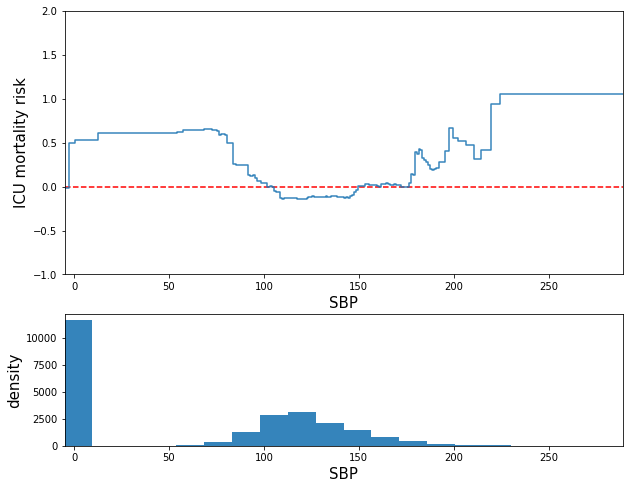

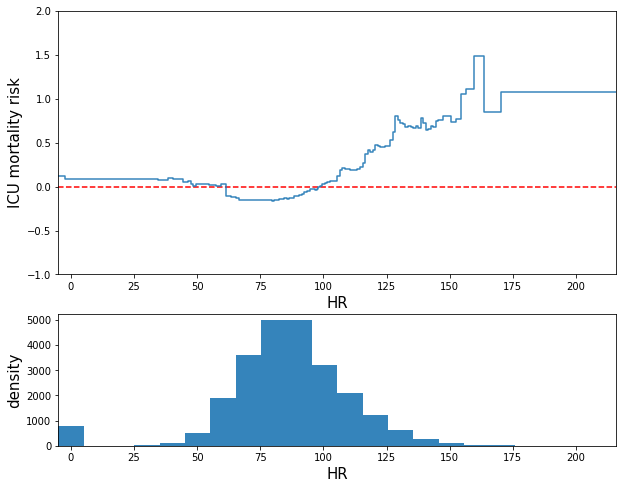

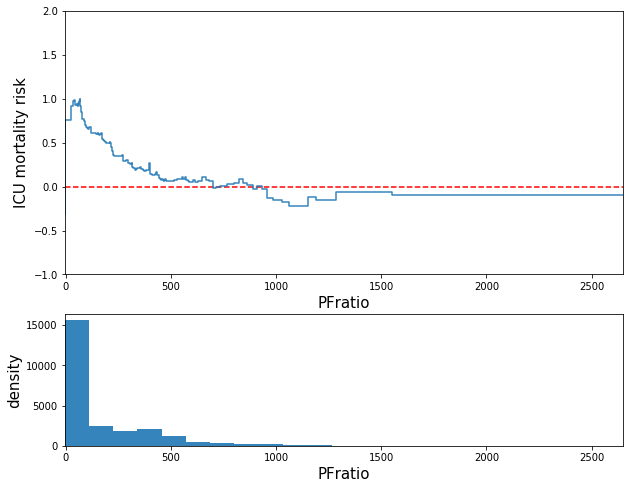

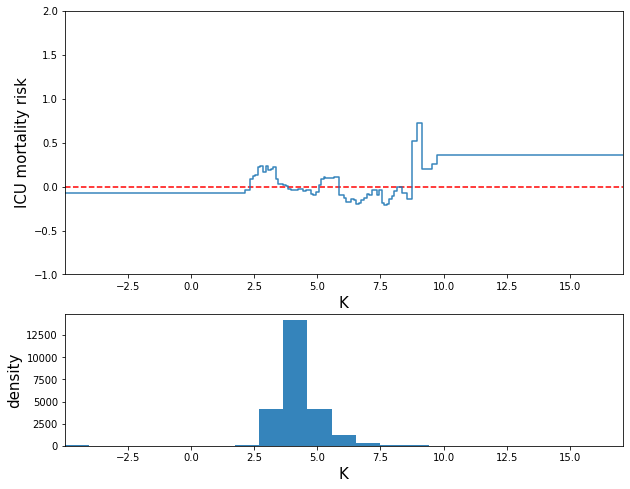

In [9]:
for i in range(len(featureNames)-1):
    if ebm.preprocessor_.col_types_[i] == 'continuous' and is_missing[featureNames[i]]:
        print(f'feature name: {featureNames[i]}')
        plt.figure(figsize=(10,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
        plt.subplot(gs[0])
        scores = ebm.additive_terms_[i]
        scores[0]=scores[1]
        bins = np.zeros(scores.shape)
        bins[1:-1] = ebm.preprocessor_.col_bin_edges_[i]
        bins[0] = ebm.preprocessor_.col_min_[i]
        bins[-1] = ebm.preprocessor_.col_max_[i]
        
        #p value for t-test
        n_samples = np.histogram(X.values[:,i],bins)[0]
        missing_group = [scores[1]] * n_samples[0]
        observed_group = []
        for j in range(1,n_samples.shape[0]):
            observed_group+=[scores[j+1]]*n_samples[j]
        p_value = ttest_ind(missing_group,observed_group,equal_var=False)
        print(n_samples[0],(X.values[:,i]==-5).sum())
        print(f'p value: {p_value}')
        
        plt.step(bins,scores,label='pre (default)',alpha=.9)
        plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
        plt.ylim([-1,2])
        plt.hlines([0],xmin=bins[0]+1e-4*(bins[-1]-bins[0]),xmax= bins[-1],colors='r',linestyles='dashed')
        plt.xlabel(featureNames[i], fontsize=15)
        plt.ylabel('ICU mortality risk', fontsize=15)
        
        plt.subplot(gs[1])
        plt.hist(X.values[:,i],ebm.preprocessor_.hist_edges_[i],alpha=.9)
        plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
        plt.xlabel(featureNames[i], fontsize=15)
        plt.ylabel('density', fontsize=15)
        plt.savefig(f'testing_MCAR/{i}_{featureNames[i]}.png', dpi=300)

In [19]:
from scipy.stats import ttest_ind

In [21]:
ttest_ind([1,2,3,4],[3,4,5,6,7,7,7,7,7],equal_var=False)

Ttest_indResult(statistic=-4.112619161025778, pvalue=0.004590940242167016)

In [27]:
i = 5
scores = ebm.additive_terms_[i]
bins = np.zeros(scores.shape)
bins[1:-1] = ebm.preprocessor_.col_bin_edges_[i]
bins[0] = ebm.preprocessor_.col_min_[i]
bins[-1] = ebm.preprocessor_.col_max_[i]
n_samples = np.histogram(X.values[:,i],bins)[0]
print(scores.shape,n_samples.shape[0],bins.shape[0],n_samples[0],(X.values[:,i]==-5).sum())

(256,) 255 256 13328 13328


In [9]:
X.shape

(24508, 17)

In [61]:
def get_onehot(ebm, X):
    
    featureNames=ebm.feature_names
    n = X.shape[0]
    X_binary = [np.ones((n,1))]
    for i, feature in enumerate(featureNames):
        if ebm.feature_types[i]=='continuous':
            bins = np.array([-10000]+list(ebm.preprocessor_.col_bin_edges_[i])+[ebm.preprocessor_.col_max_[i]])
            x_idx = np.digitize(X[feature],bins,right=True)
#             print(f"{x_idx.min()},{x_idx.max()},{bins.shape[0]}")
            assert(x_idx.min()==1 and x_idx.max()+1==bins.shape[0])
            x_bin_sub = np.zeros((n, x_idx.max()))
            x_bin_sub[np.arange(n),x_idx-1]=1
        else:
            x_bin_sub = np.zeros((n, X[feature].max()+1))
            x_bin_sub[np.arange(n),X[feature]]=1
        X_binary.append(x_bin_sub)
    
    X_binary = np.concatenate(X_binary,1)
    print(X_binary.shape)
    return X_binary

In [62]:
X_binary = get_onehot(ebm, X)

(24508, 1462)


In [66]:
featureNames=ebm.feature_names
coefs = list(ebm.intercept_)
missing_bin_idx = {}
for i, feature in enumerate(featureNames):
    if is_missing[feature]:
        missing_bin_idx[feature] = len(coefs)
    coefs += list(ebm.additive_terms_[i][1:])
coefs = np.array(coefs)

In [78]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x_full, coefs, X):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(X)
    n = len(p)
    m = coefs.shape[0]
    ans = np.zeros((m, m))
    for i in range(n):
        if (i+1)%1000==0:
            print(i)
        ans = ans + np.dot(np.transpose(X[i:i+1, :],(1,0)), X[i:i+1, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.pinv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p_value = (1 - norm.cdf(abs(t))) * 2
    return p_value

In [79]:
p_value = logit_pvalue(ebm, X_binary, coefs, X)

999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999
21999
22999
23999


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in sqrt



In [93]:
p = ebm.predict_proba(X)
n = len(p)
print(n)
m = coefs.shape[0]
ans = np.zeros((m, m))
for i in range(n):
    if (i+1)%1000==0:
        print(i)
    ans = ans + np.dot(np.transpose(X_binary[i:i+1, :],(1,0)), X_binary[i:i+1, :]) * p[i,1] * p[i, 0]

24508
999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999
21999
22999
23999


In [107]:
vcov = np.linalg.pinv(np.matrix(ans))
se = np.sqrt(np.diag(vcov))
t =  coefs/se  
p_values = (1 - norm.cdf(abs(t))) * 2

### test for coeff significance

In [108]:
for feature in missing_bin_idx:
    print(f"feature: {feature}, p value:{p_values[missing_bin_idx[feature]]}")

feature: SBP, p value:0.7505907377429375
feature: HR, p value:0.4859040310246696
feature: PFratio, p value:6.09231205483951e-08
feature: Urea, p value:0.9884900274999406
feature: WBC, p value:0.04351677049723213
feature: CO2, p value:0.897605824570703
feature: Na, p value:0.9842610952254975
feature: K, p value:0.9313341635612953
feature: Bilirubin, p value:0.014556266807650431


### test for if coeff is the same as mean coeff of non-missing group

In [110]:
missing_ratio = data_orig.isnull().mean(0)

In [112]:
for feature in missing_bin_idx:
    coef = coefs[missing_bin_idx[feature]]
    coef /= (1-missing_ratio[feature])
    p_value = (1 - norm.cdf(abs(coef/se[missing_bin_idx[feature]])))
    print(f"feature: {feature}, p value:{p_value}")

feature: SBP, p value:0.2825013987613585
feature: HR, p value:0.2359810093725001
feature: PFratio, p value:0.0
feature: Urea, p value:0.4942216738394677
feature: WBC, p value:0.02120042962652746
feature: CO2, p value:0.16110965537480526
feature: Na, p value:0.4920953962417852
feature: K, p value:0.46554085192190797
feature: Bilirubin, p value:9.615586612965465e-05
